# Image generation (plus some gold mining)

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt

from units import *
from simulation import SubhaloSimulator

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Prior

In [2]:
mass_base_unit = 1.e7 * M_s

In [3]:
alpha_mean = 1000. # 100  # 100 is just 2e8/M_s * mass_base_unit * (mass_base_unit / M_s)**-1.9
alpha_std = alpha_mean * 0.2

print(alpha_mean, "+/-", alpha_std)

beta_mean = -1.9
beta_std = 0.2

1000.0 +/- 200.0


## Draw parameters to generate

In [4]:
n_sims = 1000
n_theta_samples = 100

In [5]:
alpha = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n_sims)
beta = np.random.normal(loc=beta_mean, scale=beta_std, size=n_sims)
parameters = np.vstack((alpha, beta)).T

assert np.min(alpha) > 0.
assert np.max(beta) < -1.

## Generate data

In [6]:
sim = SubhaloSimulator(
    mass_base_unit=mass_base_unit,
    resolution=64,
    m_sub_min=100.,
)

# images = sim.rvs(alpha, beta, n_sims)
# images, t_xz, log_r_xz, latents = sim.rvs_score_ratio(alpha, beta, alpha_mean, beta_mean, n_sims)

images, t_xz, log_r_xz, log_r_xz_uncertainties, latents = sim.rvs_score_ratio_to_evidence(
    alpha,
    beta,
    alpha_mean,
    alpha_std,
    beta_mean,
    beta_std,
    n_sims,
    n_theta_samples,
)


/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
../simulation.py:385: RuntimeWarning: invalid value encountered in double_scalars
  log_r_xz_uncertainty = inverse_r_xz_uncertainty / inverse_r_xz
14:32 simulation           INFO    Simulating image 50 / 1000
14:32 simulation           INFO    Simulating image 100 / 1000
14:33 simulation           INFO    Simulating image 150 / 1000
14:34 simulation           INFO    Simulating image 200 / 1000
14:35 simulation           INFO    Simulating image 250 / 1000
14:36 simulation           INFO    Simulating image 300 / 1000
14:37 simulation           INFO    Simulating image 350 / 1000
14:38 simulation           INFO    Simulating image 400 / 1000
14:38 simulation           INFO    Simulating image 450 / 1000
14:40 simulation           INFO    Simulating image 500 / 1000
14:40 simulation           INFO    Simulating i

In [7]:
r_xz = np.exp(log_r_xz, dtype=np.float64)
y = np.zeros(n_sims)
n_subs = np.array([v[0] for v in latents])
m_subs = np.hstack([v[1] for v in latents])
pos_subs = [np.vstack((v[2], v[3])).T for v in latents]

In [8]:
if not os.path.exists("../data"):
    os.mkdir("../data")

np.save("../data/theta.npy", parameters)
np.save("../data/x.npy", images)
np.save("../data/y.npy", y)
np.save("../data/t_xz.npy", t_xz)
np.save("../data/r_xz.npy", r_xz)
np.save("../data/log_r_xz.npy", log_r_xz)
np.save("../data/log_r_xz_uncertainties.npy", log_r_xz_uncertainties)

## A first look at the data

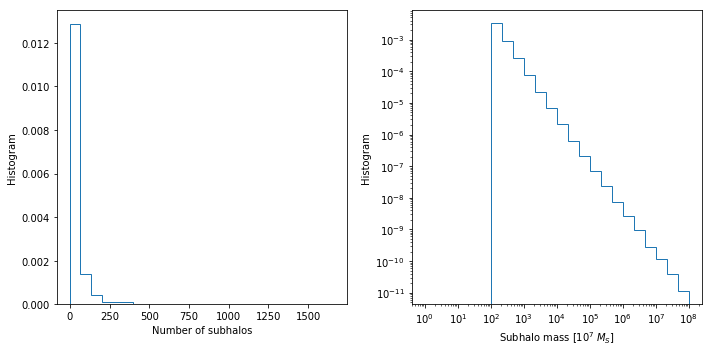

In [9]:
fig = plt.figure(figsize=(10,5))

# Number of subhalos
ax = plt.subplot(1,2,1)
nbins= min(np.max(n_subs)+1, 25)
plt.hist(n_subs, bins=nbins, range=(-0.5,np.max(n_subs)+0.5), histtype='step', density=True)
plt.xlabel(r'Number of subhalos')
plt.ylabel(r'Histogram')

# Masses
ax = plt.subplot(1,2,2)
bins = 10**(np.linspace(0, 8, 25))
plt.hist(np.array(m_subs), bins=bins, histtype='step', density=True)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.xlabel(r'Subhalo mass [$10^7 \; M_S$]')
plt.ylabel(r'Histogram')

plt.tight_layout()
plt.show()

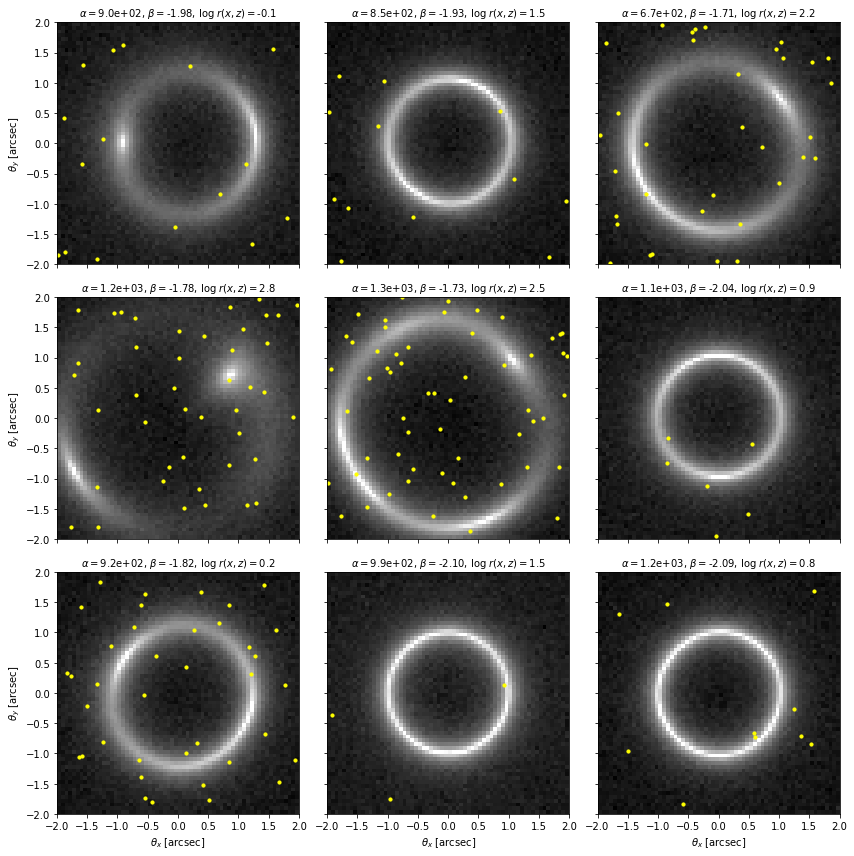

In [10]:
plt.figure(figsize=(12,12))

for i in [6,7,8,0,3,1,2,4,5]:
    if i == 6:
        ax_y = plt.subplot(3,3,i+1)
        ax_x = ax_y
    elif i in [7,8]:
        ax_x = plt.subplot(3,3,i+1, sharey=ax_y)
    elif i in [0,3]:
        ax_y = plt.subplot(3,3,i+1, sharex=ax_x)
    else:
        ax = plt.subplot(3,3,i+1, sharey=ax_y, sharex=ax_x)
        
    plt.imshow(np.log10(images[i]), vmax=3.5, cmap='gist_gray', extent=(-2.,2.,-2.,2.), origin="lower")
    plt.scatter(
        pos_subs[i][:,0], pos_subs[i][:,1], s=10., color="yellow"
    )
    
    
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    description = r"$\alpha = ${:.1e}, $\beta = ${:.2f}, $\log \; r(x,z) = ${:.1f}".format(
            alpha[i],
            beta[i],
            log_r_xz[i]
        )
    plt.title(
        description,
        fontsize=10
    )
    if i in [6,7,8]:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    if i in [0,3,6]:
        plt.ylabel(r"$\theta_y$ [arcsec]")
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    
plt.tight_layout()
plt.show()

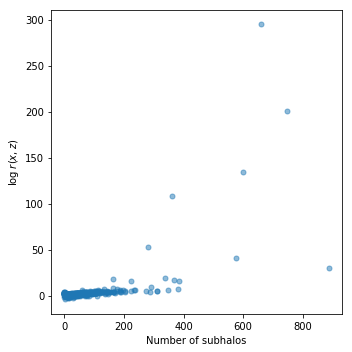

In [11]:
plt.figure(figsize=(5,5))

plt.errorbar(n_subs, log_r_xz, yerr=1.*log_r_xz_uncertainties, ls=" ", marker="o", ms=5., alpha=0.5)

#plt.xlim(0,200)
#plt.ylim(-5.,10.)
plt.xlabel("Number of subhalos")
plt.ylabel(r"$\log \; r(x,z)$")

plt.tight_layout()
plt.show()